In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import torch.onnx
import sklearn

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the default GPU device
else:
    device = torch.device("cpu")
print(device)

cpu


## Data Exploration

In [ ]:
dataframes = []
train_data_directory = "Data"
for file in os.listdir(train_data_directory):
    dataframes.append(pd.read_csv(os.path.join(train_data_directory, file), delimiter=",").iloc[:,:-1])
    print(f"{len(dataframes)-1}:{file}")

0:User27_ArcPursuit_0.txt
1:User27_LinearPursuit_0.txt
2:User27_LinearPursuit_2.txt
3:User27_ArcPursuit_2.txt
4:User27_RapidAvoid_2.txt
5:User27_RapidMovement_0.txt
6:User27_RapidMovement_2.txt
7:User27_RapidMovement_1.txt
8:User27_RapidAvoid_0.txt
9:User27_RapidAvoid_1.txt
10:User27_LinearPursuit_1.txt
11:User27_ArcPursuit_1.txt


In [ ]:
for j in range(len(dataframes)):
    df = dataframes[j]
    labelx = []
    labely = []
    labelz = []
    for i in range(df.shape[0] - 1):
        label_row = df.iloc[i + 1]
        labelx.append(label_row["forward.x"])
        labely.append(label_row["forward.y"])
        labelz.append(label_row["forward.z"])
    ##  change the gaze z axis value
    #df['gaze_direct_L.z'] = 1
    #df['gaze_direct_R.z'] = 1
    ##
    df = df.iloc[:-1, :]
    df["label.x"] = labelx
    df["label.y"] = labely
    df["label.z"] = labelz
    dataframes[j] = df

dataframes[3].head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638213146203589906,818048,67930,0.012741,-0.072876,1,0.025421,-0.101425,1,-0.014492,0.394708,0.918692,-0.014278,0.394425,0.918817
1,638213146203669911,818056,67931,0.013031,-0.073608,1,0.025192,-0.100693,1,-0.014278,0.394425,0.918817,-0.013979,0.394125,0.918951
2,638213146203749914,818064,67932,0.013062,-0.073334,1,0.024796,-0.099915,1,-0.013979,0.394125,0.918951,-0.013910,0.393914,0.919042
3,638213146203829913,818072,67933,0.012955,-0.074478,1,0.022964,-0.099152,1,-0.013910,0.393914,0.919042,-0.013910,0.393914,0.919042
4,638213146203919918,818081,67933,0.012909,-0.074524,1,0.021103,-0.098190,1,-0.013910,0.393914,0.919042,-0.014081,0.394113,0.918954


In [ ]:
min_size = float('inf')
for df in dataframes:
    if df.shape[0] < min_size:
        min_size = df.shape[0]

for i in range(len(dataframes)):
    dataframes[i] = dataframes[i][:min_size]


len(dataframes), min_size


(12, 10799)

(10799, 15)


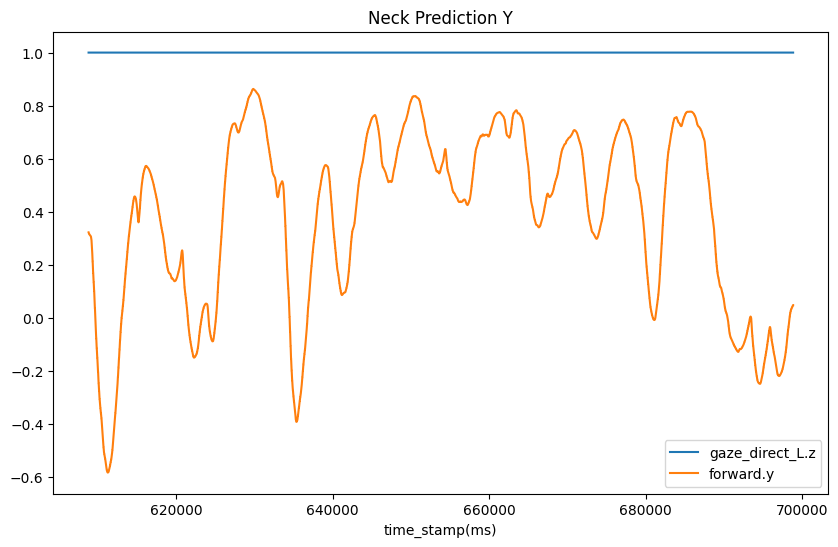

(10799, 15)


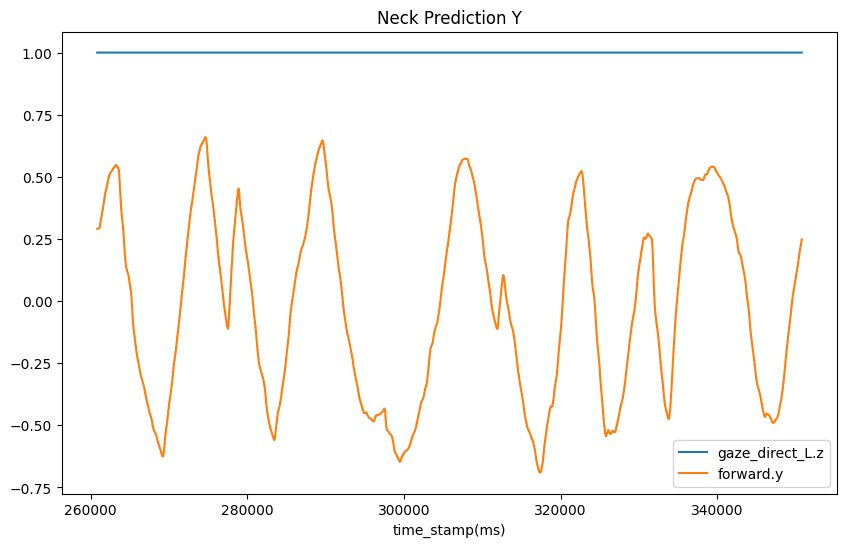

(10799, 15)


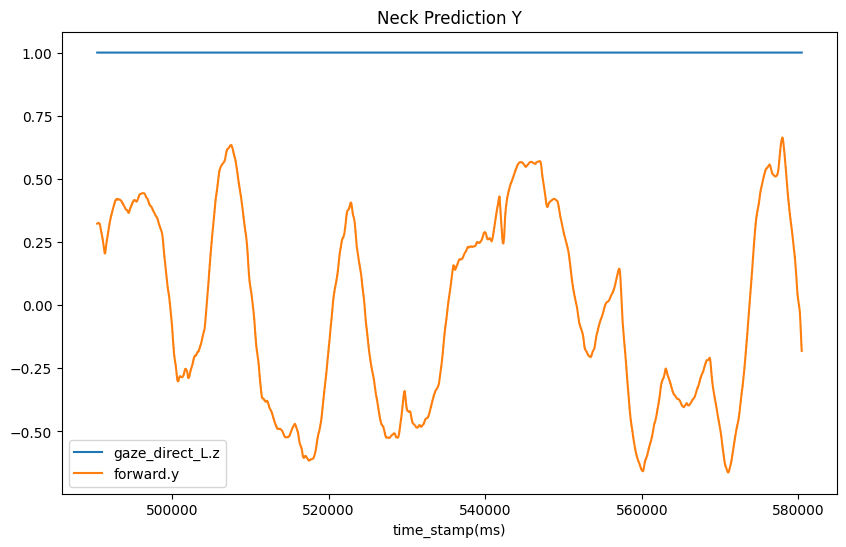

(10799, 15)


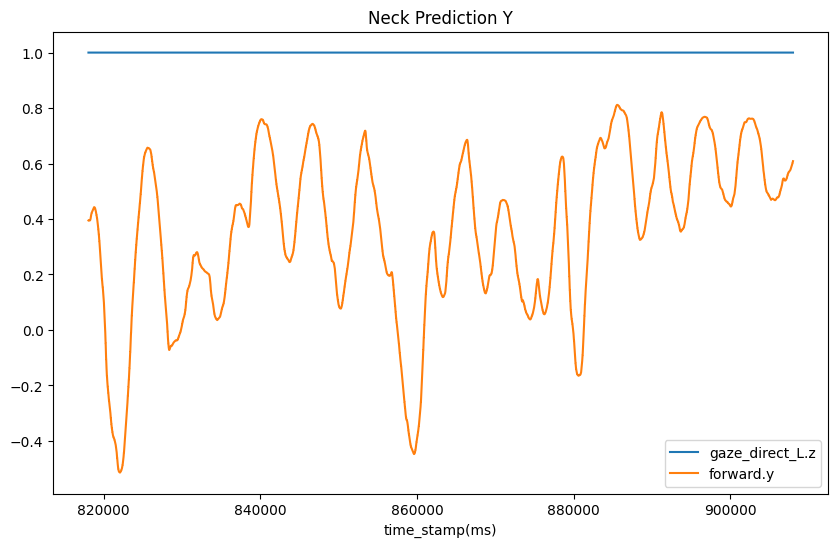

(10799, 15)


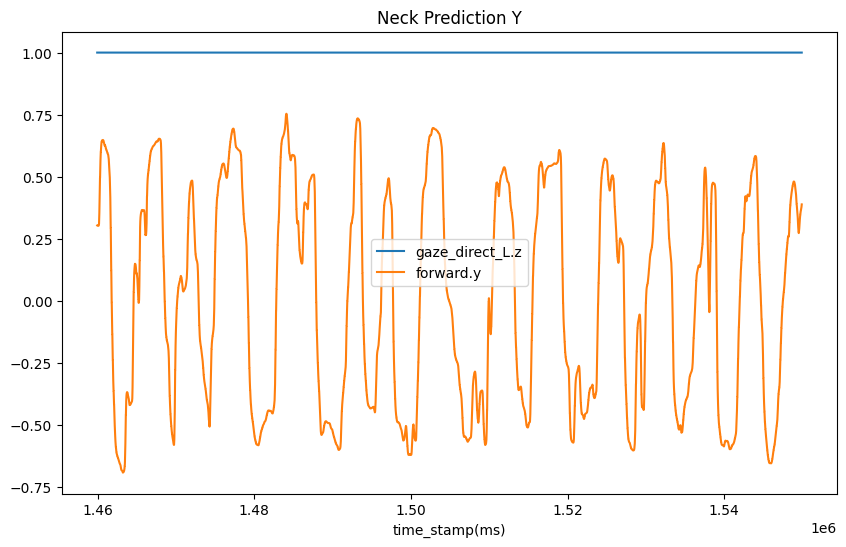

(10799, 15)


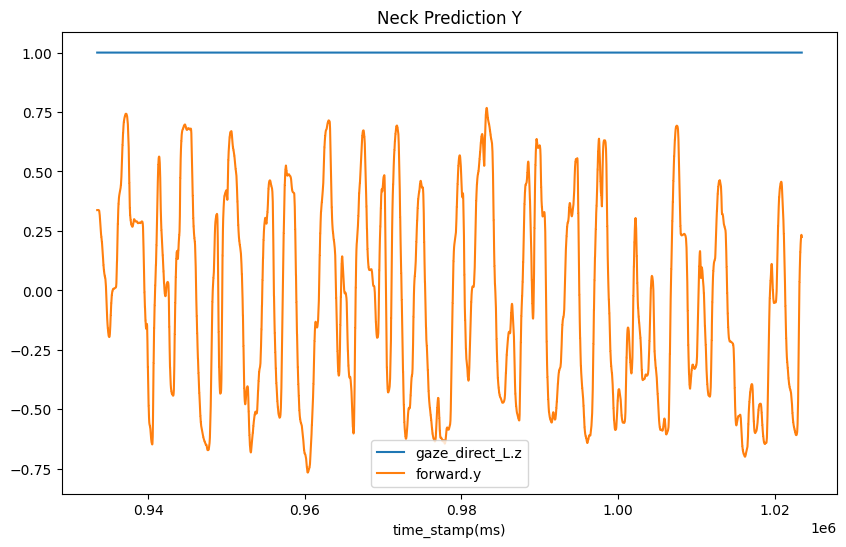

(10799, 15)


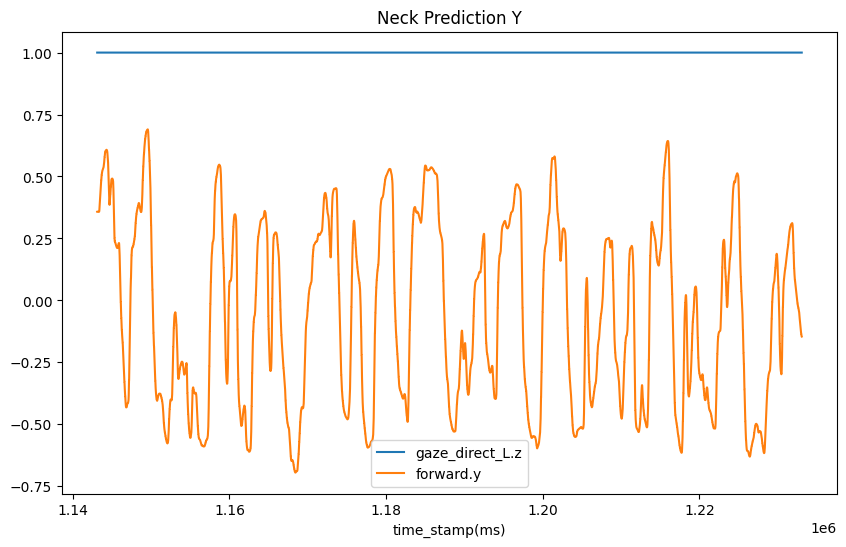

(10799, 15)


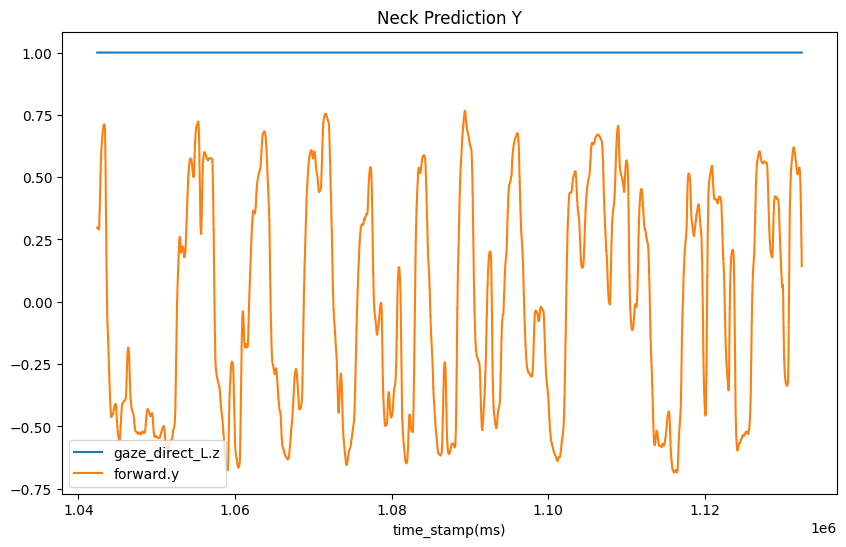

(10799, 15)


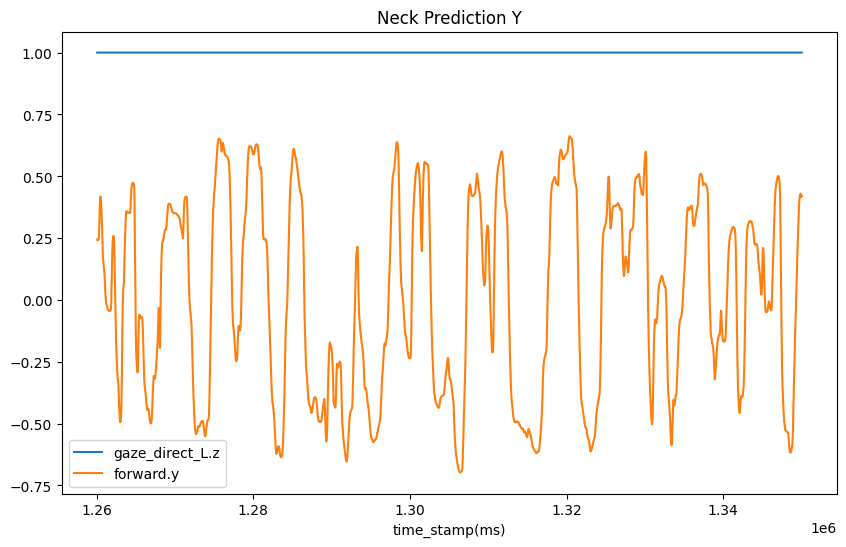

(10799, 15)


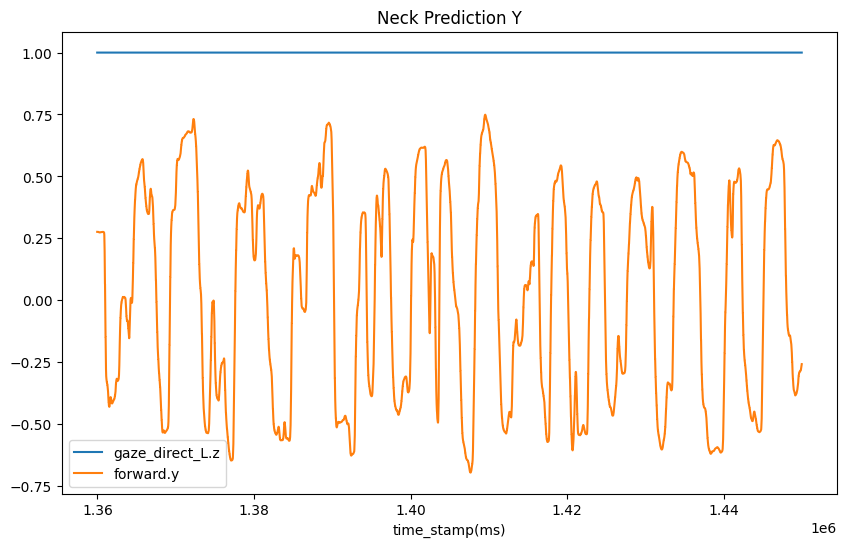

(10799, 15)


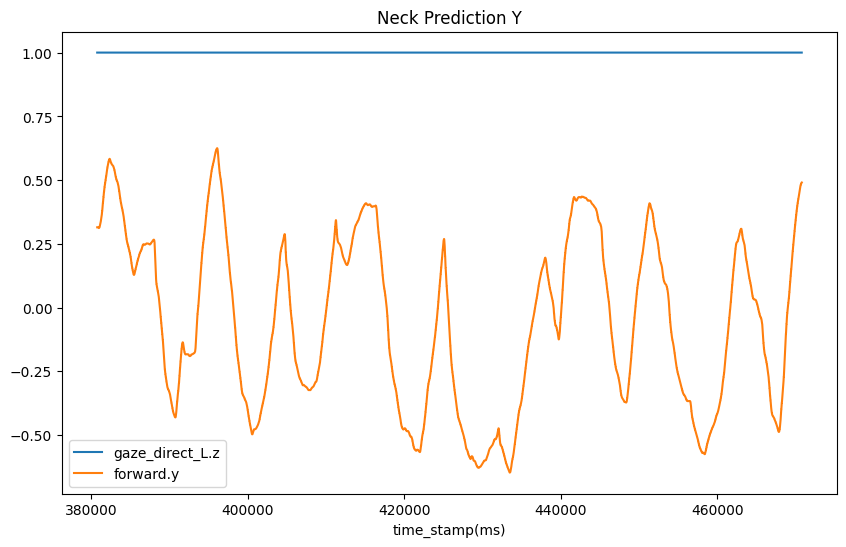

(10799, 15)


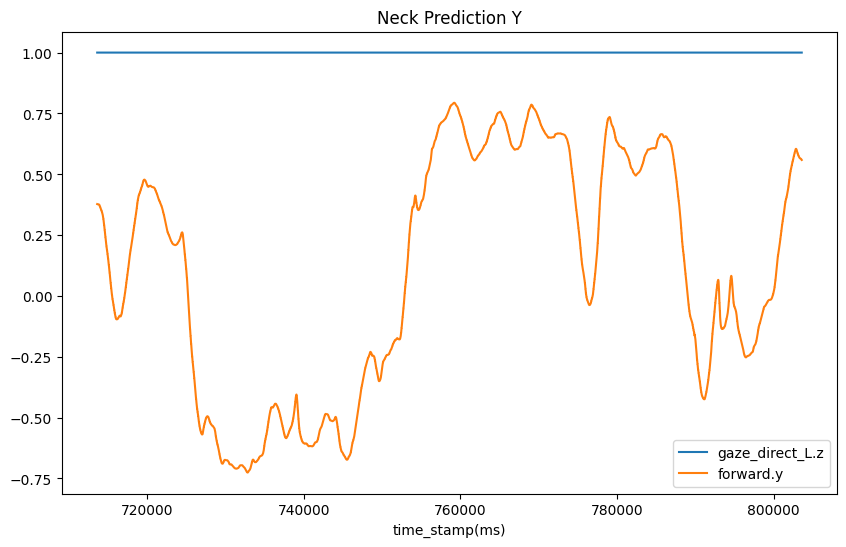

In [ ]:
for df in dataframes:
    print(df.shape)
    plt.figure(figsize=(10,6))
    x = df["time_stamp(ms)"]
    plt.xlabel("time_stamp(ms)")

    plt.plot(x, df["gaze_direct_L.z"], label = "gaze_direct_L.z")
    plt.plot(x, df["forward.y"], label="forward.y")


    plt.title(f"Neck Prediction Y")
    plt.legend()
    plt.show()

(10799, 15)


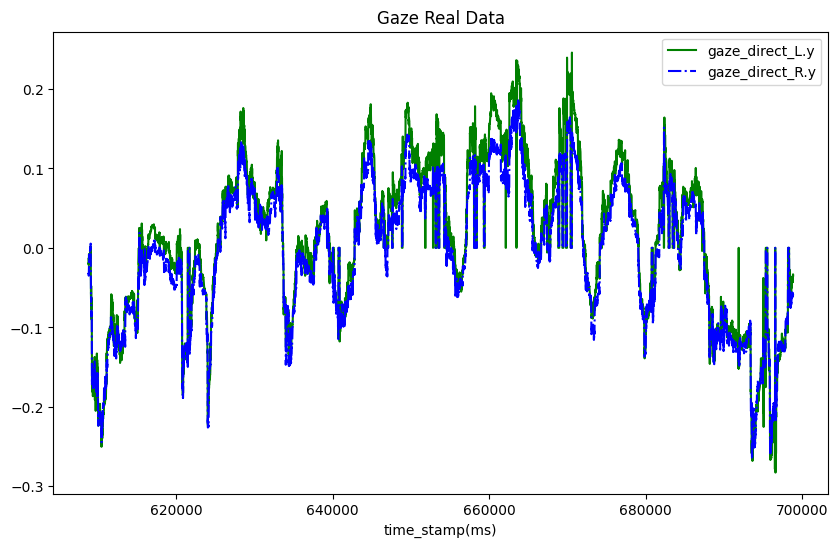

(10799, 15)


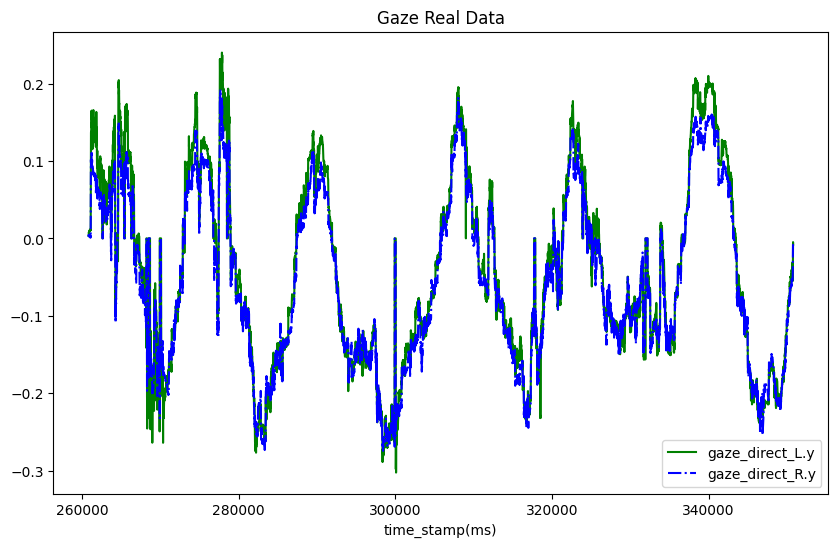

(10799, 15)


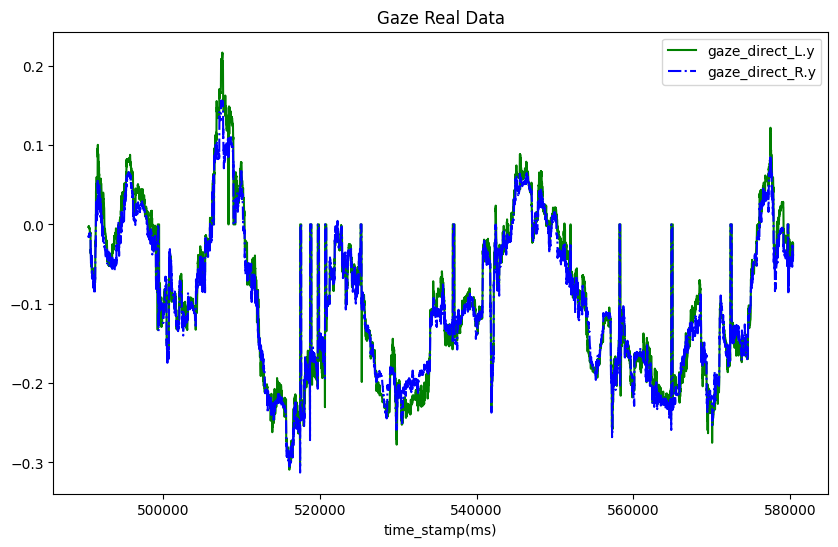

(10799, 15)


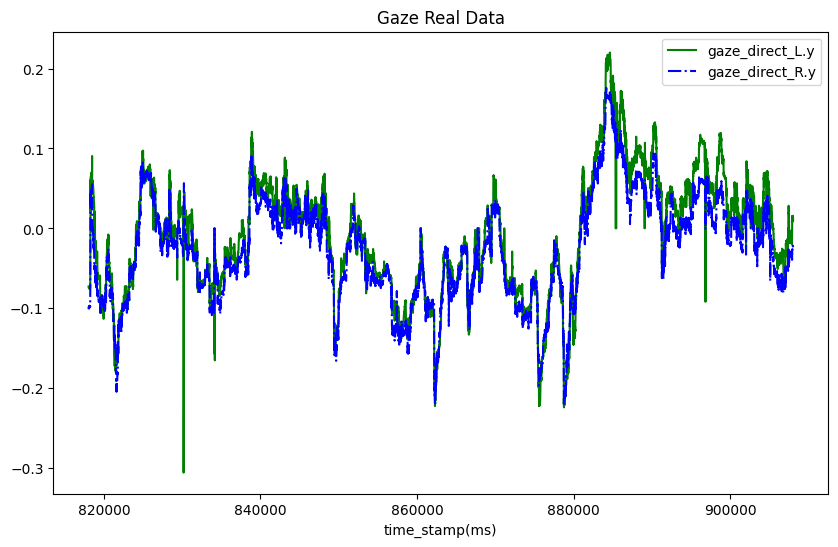

(10799, 15)


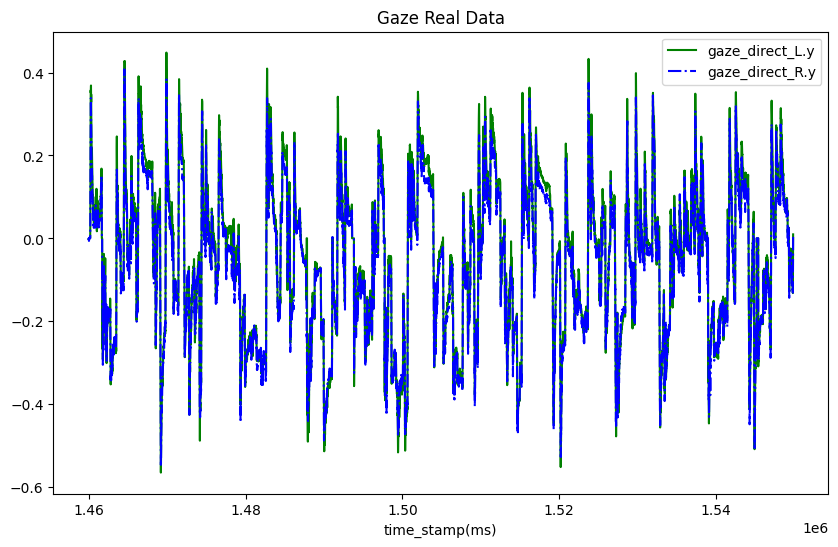

(10799, 15)


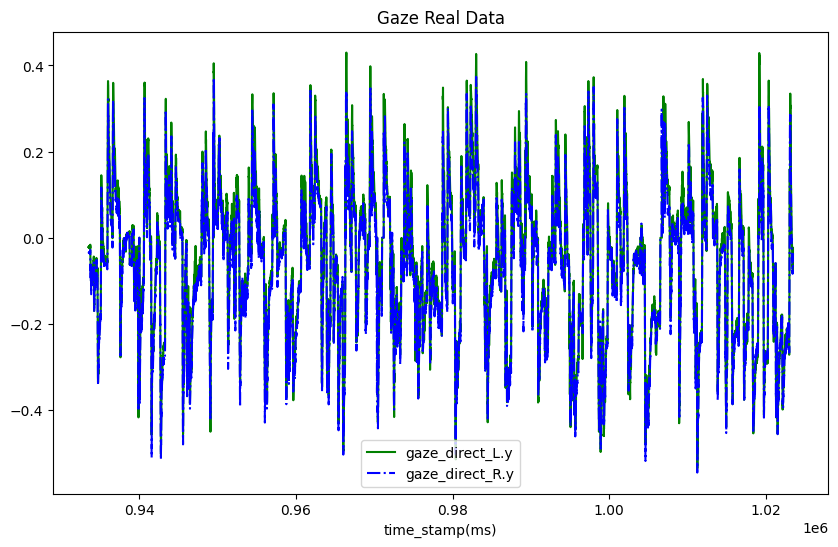

(10799, 15)


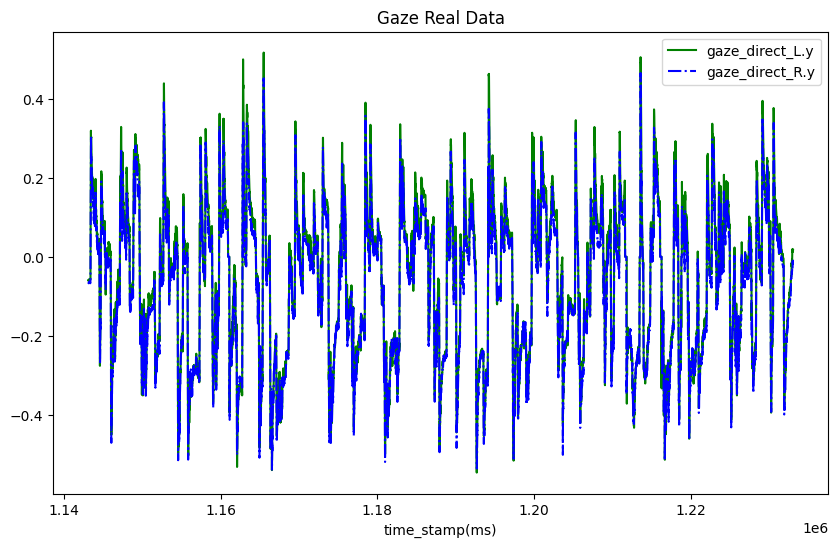

(10799, 15)


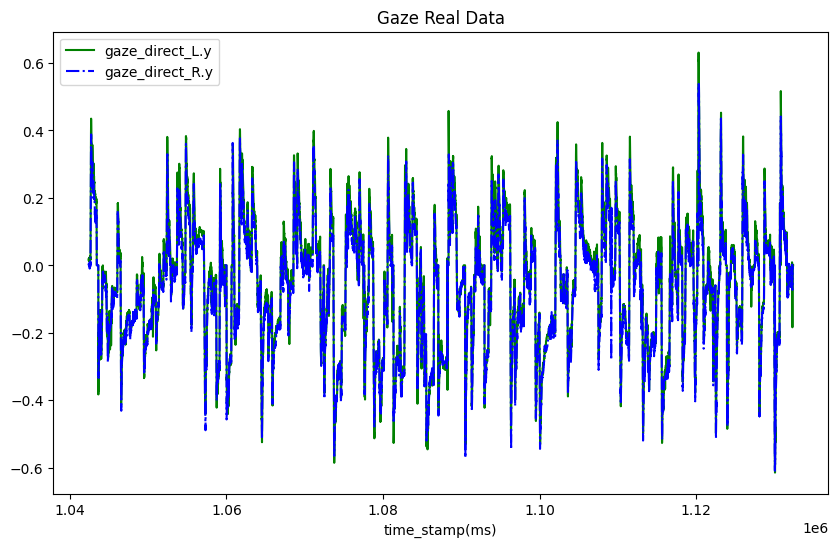

(10799, 15)


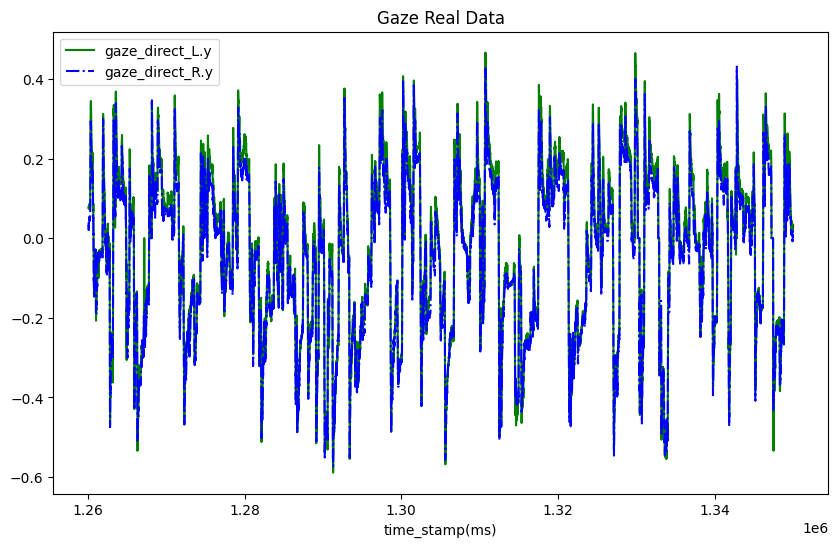

(10799, 15)


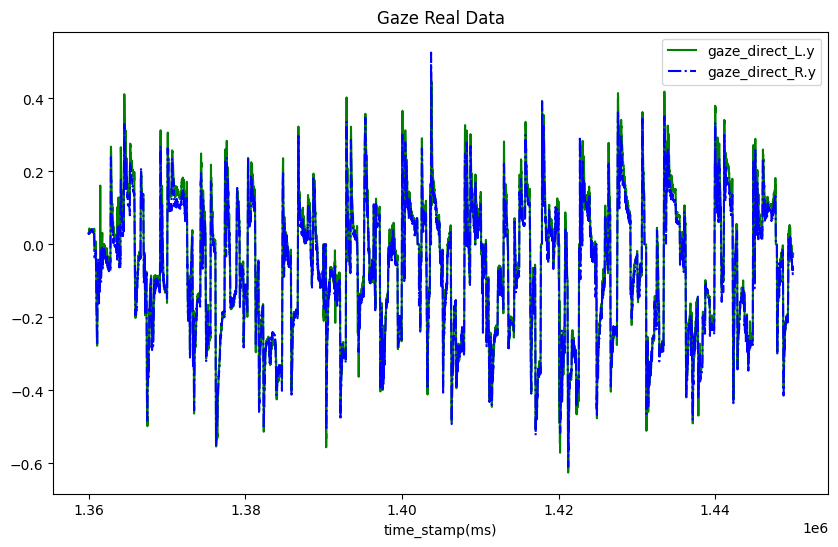

(10799, 15)


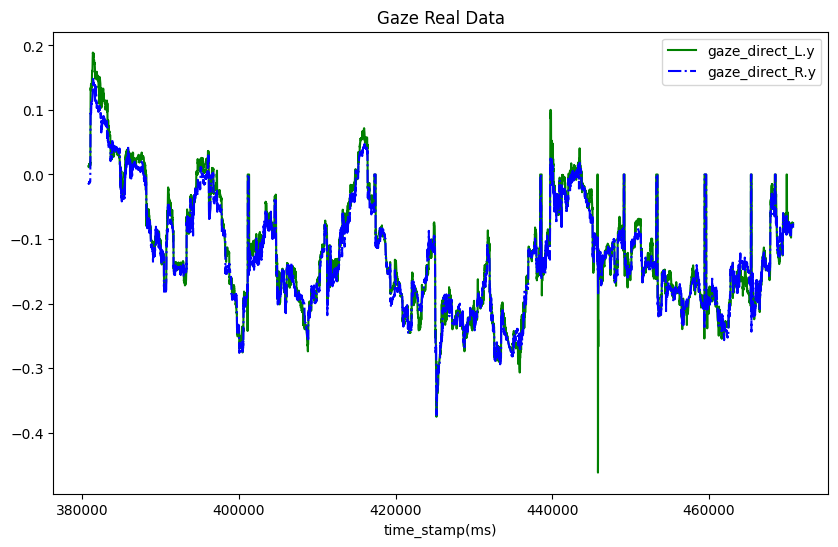

(10799, 15)


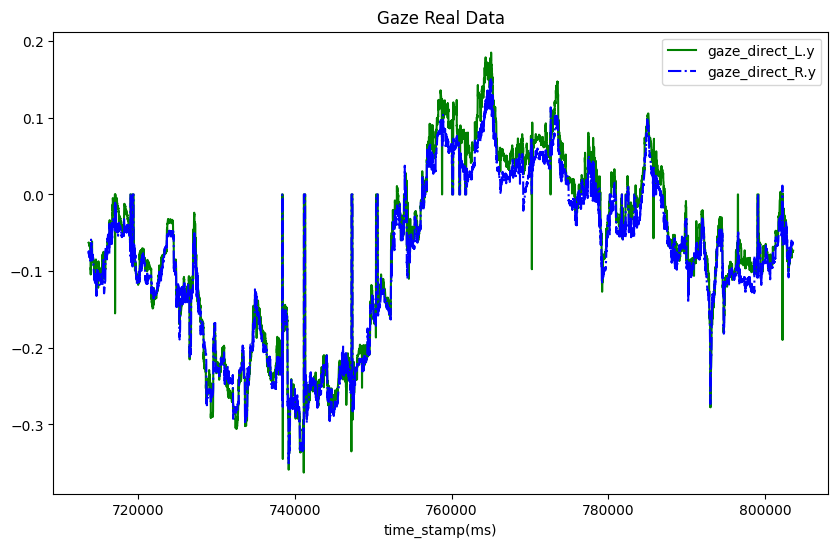

In [ ]:
for df in dataframes:
    print(df.shape)
    plt.figure(figsize=(10,6))
    x = df["time_stamp(ms)"]
    plt.xlabel("time_stamp(ms)")

    #plt.plot(x, df['gaze_direct_L.x'],'b-', label = "gaze_direct_L.x")
    #plt.plot(x, df['gaze_direct_R.x'],'g-.', label = "gaze_direct_R.x")
    plt.plot(x, df['gaze_direct_L.y'],'g-', label = "gaze_direct_L.y")
    plt.plot(x, df['gaze_direct_R.y'],'b-.', label = "gaze_direct_R.y")



    plt.title(f"Gaze Real Data")
    plt.legend()
    plt.show()

(10799, 15)


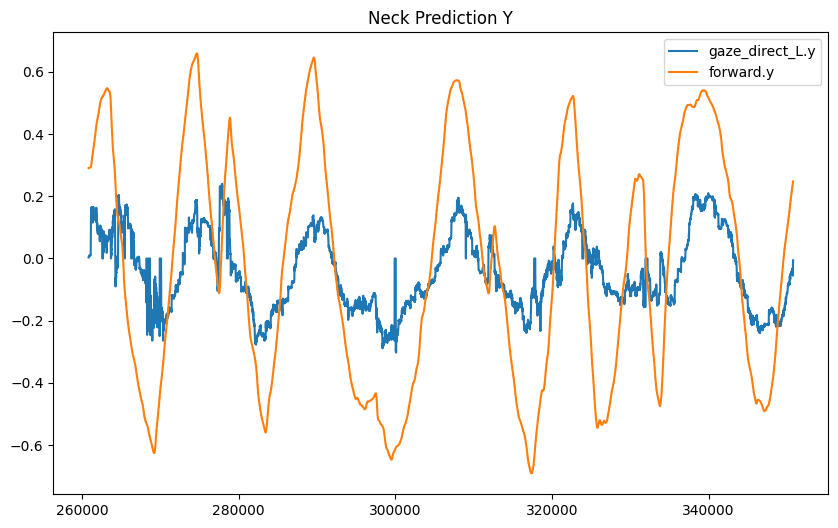

In [ ]:
#The chat shows the relation of gaze and forward in the raw data.

df = dataframes[1]
print(df.shape)
plt.figure(figsize=(10,6))
x = df["time_stamp(ms)"]


plt.plot(x, df["gaze_direct_L.y"], label = "gaze_direct_L.y")
plt.plot(x, df["forward.y"], label="forward.y")

plt.title("Neck Prediction Y")
plt.legend()
plt.show()


## GRU Model

In [ ]:
X_series = []
y_series = []
for df in dataframes:
    X = df.iloc[:, 3:-3].to_numpy() # gaze data and forward data
    y = df.iloc[:, -3:].to_numpy()  # label data

    X = Variable(torch.Tensor(X)) # trnsform to Tensor object (2d)
    y = Variable(torch.Tensor(y))

    X = torch.reshape(X, (X.shape[0], 1, X.shape[1])) # 3d Tensor object
    X_series.append(X)
    y_series.append(y)


X_series = torch.cat(X_series, dim=1)

y_series = torch.stack(y_series, dim=1)
print(X_series.shape, y_series.shape)

torch.Size([10799, 12, 9]) torch.Size([10799, 12, 3])


In [ ]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, output_size=3, hidden_size=9):
        super(CustomGRU, self).__init__() ##nn.Module __init__()
        self.num_classes = output_size
        self.num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Linear(self.hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, self.num_classes)
        )

    def forward(self, x, h_0=None):
        if h_0 is None:
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)



        output, hn = self.lstm(x, h_0)
        _hn = hn.view(-1, self.hidden_size)
        out = self.fc(_hn)
        return output, out, hn

In [ ]:
model_0 = CustomGRU(9).to(device)
model_0

CustomGRU(
  (lstm): GRU(9, 9, batch_first=True)
  (fc): Sequential(
    (0): Tanh()
    (1): Linear(in_features=9, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
with torch.inference_mode():
  LSTM_preds, untrained_preds, hn = model_0( X_series.to(device))

print(X_series.shape, y_series.shape)
print( LSTM_preds.shape, untrained_preds.shape, hn.shape)

print(f"First 10 LSTM predictions:\n{LSTM_preds[0,0,:10]}")
print(f"First 10 untrained predictions:\n{untrained_preds[0,:10]}")
print(f"\nFirst 10 labels:\n{y_series[0,0, :10]}")
print(f'hn:{hn}')

training_range = int(X_series.shape[0]*0.8)
training_range

torch.Size([10799, 12, 9]) torch.Size([10799, 12, 3])
torch.Size([10799, 12, 9]) torch.Size([10799, 3]) torch.Size([1, 10799, 9])
First 10 LSTM predictions:
tensor([ 0.2866,  0.0295,  0.1198, -0.1801, -0.1202, -0.0583,  0.1127,  0.0417,
         0.0260])
First 10 untrained predictions:
tensor([ 0.0491,  0.0844, -0.0659])

First 10 labels:
tensor([-0.0384,  0.3213,  0.9462])
hn:tensor([[[0.6981, 0.0958, 0.2650,  ..., 0.3233, 0.1067, 0.0465],
         [0.6981, 0.0959, 0.2650,  ..., 0.3233, 0.1067, 0.0465],
         [0.6981, 0.0957, 0.2653,  ..., 0.3229, 0.1073, 0.0465],
         ...,
         [0.6453, 0.1511, 0.2398,  ..., 0.3112, 0.1761, 0.0917],
         [0.6450, 0.1503, 0.2392,  ..., 0.3107, 0.1765, 0.0908],
         [0.6448, 0.1500, 0.2385,  ..., 0.3094, 0.1773, 0.0897]]])


8639

## Training Loop and Results

In [ ]:
def train(model, X, y, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    preds = torch.zeros(y.shape).to(device)
    loss = 0
    for j in range(X.shape[1]):
        instance = X[0:1, j:j+1, :]
        hn = None
        for i in range(training_range):
            raw_pred, pred, hn = model(instance, hn)
            pred = nn.functional.normalize(pred)
            #preds[i, j] = pred
            cur_loss = criterion(pred, y[i:i+1, j])
            loss += criterion(pred, y[i:i+1, j]) / (training_range * X.shape[1])
            #losses.append(cur_loss.item())

            if i < training_range-1:
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,0:3] - pred[0], (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,3:6] - pred[0], (1,3)))
                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
    #loss = criterion(preds[:6000], y[:6000])
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def val(model, X, y, criterion, device):
    model.eval()
    preds = torch.zeros(y.shape).to(device)
    for j in range(X.shape[1]):
        instance = X[0:1, j:j+1, :]
        hn = None
        for i in range(X.shape[0]):
            raw_pred, pred, hn = model(instance, hn)
            pred = nn.functional.normalize(pred)
            preds[i, j] = pred
            if i < X.shape[0] - 1:
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,0:3] - pred[0], (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,3:6] - pred[0], (1,3)))
                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
    loss = criterion(preds[training_range:], y[training_range:])
    return loss.item()

In [ ]:
def train_loop(model, X, y, optimizer, device, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    counter = 0
    X = X.to(device)
    y = y.to(device)
    min_val_loss = val(model, X, y, criterion, device)
    for epoch in range(num_epochs):
        train_loss = train(model, X, y, optimizer, criterion, device)
        train_losses.append(train_loss)

        val_loss = val(model, X, y, criterion, device)
        val_losses.append(val_loss)

        print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, train_loss,
                                                                 val_losses[epoch]))
        if val_losses[epoch] < min_val_loss:
            min_val_loss = val_losses[epoch]
            counter = 0
            torch.save(model.state_dict(), "best_val.pth")
        else:
            counter += 1
            if counter > 10:
                break

        if epoch+1 % 10 == 0:
            scheduler.step()

    return train_losses, val_losses

In [ ]:
learning_rate = 0.1
criterion = torch.nn.MSELoss()

#device = torch.device("cuda")

lr_xyz = CustomGRU(input_size=9).to(device)
optimizer = torch.optim.Adam(lr_xyz.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
train_losses, val_losses = train_loop(lr_xyz, X_series, y_series, optimizer, device, scheduler, 1000)

Epoch: 0, train loss: 0.92416, val loss: 0.29661
Epoch: 1, train loss: 0.34108, val loss: 0.18064
Epoch: 2, train loss: 0.20031, val loss: 0.16487
Epoch: 3, train loss: 0.13898, val loss: 0.11752
Epoch: 4, train loss: 0.09990, val loss: 0.12483
Epoch: 5, train loss: 0.13425, val loss: 1.11165
Epoch: 6, train loss: 1.08711, val loss: 1.13382
Epoch: 7, train loss: 1.11456, val loss: 1.13895
Epoch: 8, train loss: 1.12027, val loss: 1.13626
Epoch: 9, train loss: 1.11613, val loss: 1.12932
Epoch: 10, train loss: 1.10706, val loss: 1.12020
Epoch: 11, train loss: 1.09583, val loss: 1.11013
Epoch: 12, train loss: 1.08382, val loss: 1.09992
Epoch: 13, train loss: 1.07194, val loss: 1.09002
Epoch: 14, train loss: 1.06061, val loss: 1.08063


In [ ]:
learning_rate = 0.0001
criterion = torch.nn.MSELoss()

device = torch.device("cuda")
lr_xyz = CustomGRU(input_size=9).to(device)
lr_xyz.load_state_dict(torch.load("best_val_gru_wZ.pth"))
optimizer = torch.optim.Adam(lr_xyz.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
torch.onnx.export(lr_xyz.cpu(),               # model being run
                  (X[0:1, 0:1, :], torch.zeros(1, 1, 9), torch.zeros(1, 1, 9)), # model input (or a tuple for multiple inputs)
                  "lr_xyz_gru_wZ.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input', 'h0', 'c0'],   # the model's input names
                  output_names = ['output', 'hn', 'cn']) # the model's output names

C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\utils.py:687: Use

<b>Result<b>

In [ ]:
X = X_series[:, 0:1, :]
y = y_series[:, 0, :]

print(X.shape, y.shape)
lr_xyz.to(device)

torch.Size([7195, 1, 9]) torch.Size([7195, 3])


CustomLSTM(
  (lstm): LSTM(9, 9, batch_first=True)
  (fc): Sequential(
    (0): Tanh()
    (1): Linear(in_features=9, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = np.array([X[0, 0, 6:9].data.numpy()])
data_predict = np.append(data_predict, train_predict.data.cpu().numpy(), axis=0)

dataY_plot = np.array([X[0, 0, 6:9].data.numpy()])
dataY_plot = np.append(dataY_plot, y.data.numpy(), axis=0)
print(data_predict.shape, dataY_plot.shape)

(7196, 3) (7196, 3)


In [ ]:
data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = nn.functional.normalize(pred)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

(7196, 3)


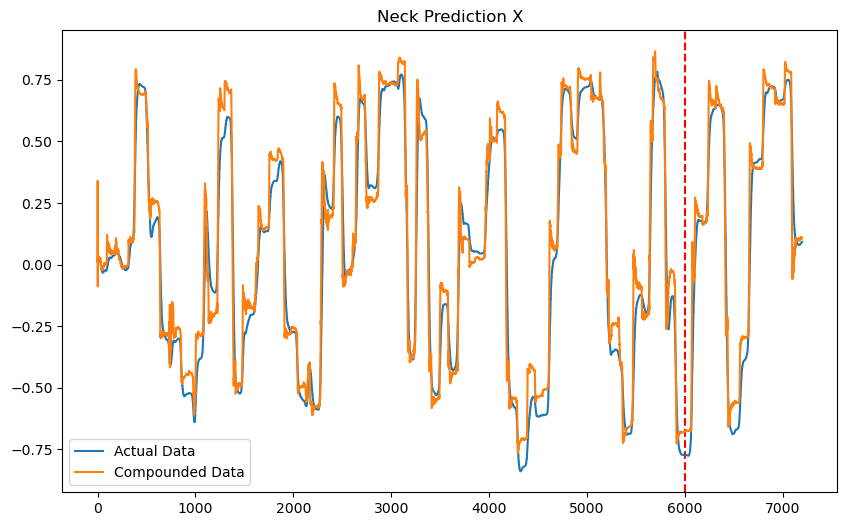

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 0], label="Actual Data")
#plt.plot(data_predict[:, 0], label="Predicted Data")
plt.plot(data_compound[:, 0], label="Compounded Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

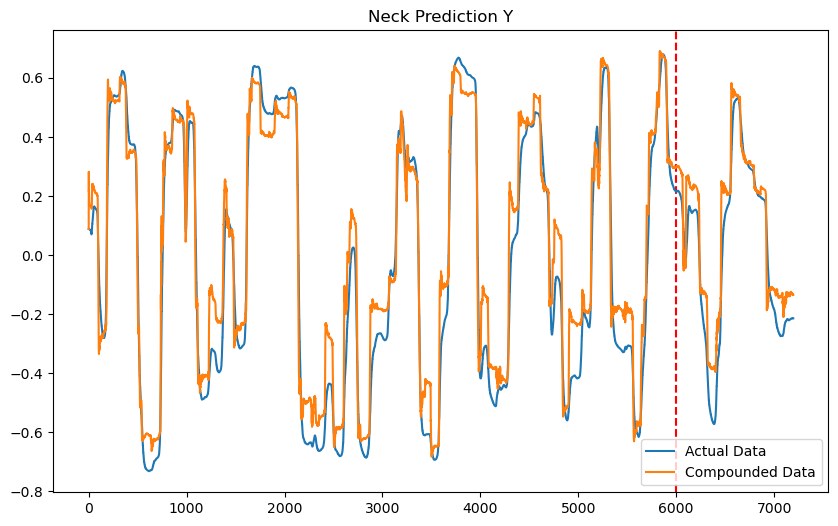

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 1], label="Actual Data")
#plt.plot(data_predict[:, 1], label="Predicted Data")
plt.plot(data_compound[:, 1], label="Compounded Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

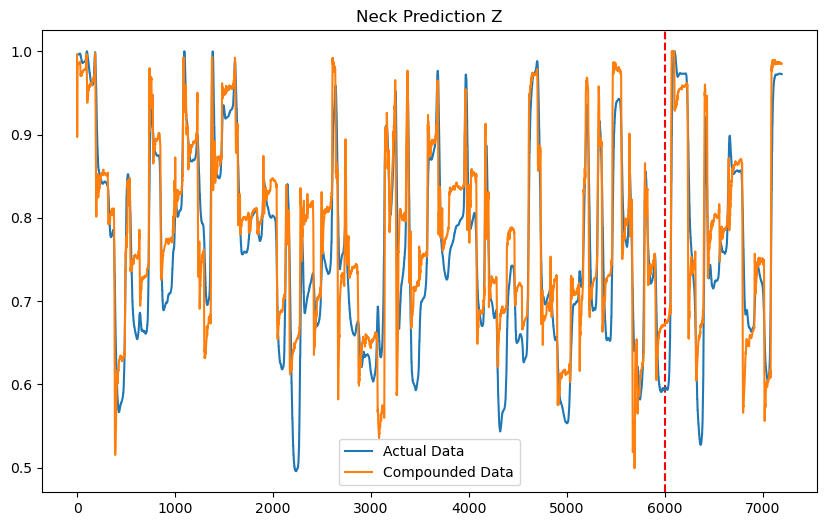

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 2], label="Actual Data")
#plt.plot(data_predict[:, 2], label="Predicted Data")
plt.plot(data_compound[:, 2], label="Compounded Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()

## Testing on New Series

In [ ]:
df = pd.read_csv("../EyeTrackingTest/Data/Test/2_1.txt", delimiter=",").iloc[:, :-1]

In [ ]:
labelx = []
labely = []
labelz = []
for i in range(df.shape[0] - 1):
    label_row = df.iloc[i + 1]
    labelx.append(label_row["forward.x"])
    labely.append(label_row["forward.y"])
    labelz.append(label_row["forward.z"])

df = df.iloc[:-1, :]
df["label.x"] = labelx
df["label.y"] = labely
df["label.z"] = labelz
df.head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638001315885795054,181877,10229,0.002441,0.089676,0.995956,0.026138,0.096710,0.994965,0.032196,0.070567,0.996987,0.032279,0.070550,0.996986
1,638001315885875052,181885,10230,0.002487,0.090622,0.995880,0.026138,0.095886,0.995041,0.032279,0.070550,0.996986,0.032443,0.070451,0.996988
2,638001315885955057,181893,10231,0.002533,0.090637,0.995865,0.026108,0.096298,0.994995,0.032443,0.070451,0.996988,0.032568,0.070438,0.996984
3,638001315886045056,181902,10232,0.001099,0.088852,0.996033,0.025070,0.096069,0.995056,0.032568,0.070438,0.996984,0.032568,0.070438,0.996984
4,638001315886125064,181910,10232,0.000565,0.089035,0.996018,0.024841,0.095840,0.995071,0.032568,0.070438,0.996984,0.032711,0.070426,0.996981


In [ ]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

(7200, 9) (7200, 3)


In [ ]:
X = Variable(torch.Tensor(X))
y = Variable(torch.Tensor(y))

X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = train_predict.data.cpu().numpy()
dataY_plot = y.data.numpy()

data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

plt.figure(figsize=(10,6))

plt.plot(data)
plt.plot(dataY_plot[:, 0], label="Actual Data")
plt.plot(data_compound[:, 0], label="Predicted Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

(7201, 3)


NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 1], label="Actual Data")
plt.plot(data_compound[:, 1], label="Predicted Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 2], label="Actual Data")
plt.plot(data_compound[:, 2], label="Predicted Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()